# 1. Build an image segmentation model using pytorch

In [2]:
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define Dataset Class
class BirdDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Masks are single-channel
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Step 3: Define Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Step 4: Update Paths to Google Drive
base_dir = '/content/drive/MyDrive/new_dataset'  # Update to your Drive folder path

train_image_dir = os.path.join(base_dir, 'train/images')
train_mask_dir = os.path.join(base_dir, 'train/masks')

valid_image_dir = os.path.join(base_dir, 'valid/images')
valid_mask_dir = os.path.join(base_dir, 'valid/masks')

test_image_dir = os.path.join(base_dir, 'test/images')
test_mask_dir = os.path.join(base_dir, 'test/masks')

# Step 5: Create Dataset and DataLoader
train_dataset = BirdDataset(train_image_dir, train_mask_dir, transform=transform)
valid_dataset = BirdDataset(valid_image_dir, valid_mask_dir, transform=transform)
test_dataset = BirdDataset(test_image_dir, test_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 6: Example Usage
for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])


In [48]:
import torch
import torch.nn as nn
from timm import create_model

class ConvNeXtEncoder(nn.Module):
    def __init__(self, model_name='convnext_tiny', pretrained=True):
        super(ConvNeXtEncoder, self).__init__()
        model = create_model(model_name, pretrained=pretrained, features_only=True, out_indices=(0, 1, 2, 3))
        self.layers = model

    def forward(self, x):
        features = self.layers(x)
        return features  # Returns 5 feature maps for U-Net

class UNetDecoder(nn.Module):
    def __init__(self, num_classes):
        super(UNetDecoder, self).__init__()
        # Decoder block definitions
        self.up3 = self._upsample_block(768 + 384, 384)
        self.up2 = self._upsample_block(384 + 192, 192)
        self.up1 = self._upsample_block(192 + 96, 96)
        self.up0 = self._upsample_block(96, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, features):
        x0, x1, x2, x3 = features

        u3 = self.up3(torch.cat([F.interpolate(x3, x2.shape[2:], mode='bilinear'), x2], dim=1))
        u2 = self.up2(torch.cat([F.interpolate(u3, x1.shape[2:], mode='bilinear'), x1], dim=1))
        u1 = self.up1(torch.cat([F.interpolate(u2, x0.shape[2:], mode='bilinear'), x0], dim=1))
        u0 = self.up0(F.interpolate(u1, scale_factor=2, mode='bilinear'))

        out = self.final_conv(u0)
        out = self.final_upsample(out)  # Final upsampling to match 256x256
        return out


# Full Model
class ConvNeXtUNet(nn.Module):
    def __init__(self, num_classes=2, model_name='convnext_tiny', pretrained=True):
        super(ConvNeXtUNet, self).__init__()
        self.encoder = create_model(model_name, pretrained=pretrained, features_only=True, out_indices=(0, 1, 2, 3))
        self.decoder = UNetDecoder(num_classes)

    def forward(self, x):
        features = self.encoder(x)  # Outputs: [x0, x1, x2, x3]
        return self.decoder(features)



# Example
model = ConvNeXtUNet(num_classes=2)
inp = torch.randn(1, 3, 256, 256)
out = model(inp)
print(out.shape)


torch.Size([1, 2, 256, 256])


# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from google.colab import drive
from tqdm import tqdm


# Step 2: Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 3: Dataset and DataLoader (Use existing BirdDataset)
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/new_dataset'

train_image_dir = os.path.join(base_dir, 'train/images')
train_mask_dir = os.path.join(base_dir, 'train/masks')

valid_image_dir = os.path.join(base_dir, 'valid/images')
valid_mask_dir = os.path.join(base_dir, 'valid/masks')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = BirdDataset(train_image_dir, train_mask_dir, transform=transform)
valid_dataset = BirdDataset(valid_image_dir, valid_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Step 4: Initialize Model, Loss, Optimizer
model = ConvNeXtUNet(num_classes=2, model_name='convnext_tiny', pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Step 5: Training and Validation Loop
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
      images = images.to(device)
      masks = masks.to(device).long()  # Convert masks to torch.long

      # Ensure masks are squeezed to (N, H, W)
      if masks.dim() == 4 and masks.size(1) == 1:
          masks = masks.squeeze(1)

      optimizer.zero_grad()
      outputs = model(images)  # (N, C, H, W)
      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * images.size(0)


    train_loss /= len(train_loader.dataset)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validating"):
            images = images.to(device)
            masks = masks.to(device).long()  # Convert masks to torch.long

            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(valid_loader.dataset)


    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model weights saved!")

print("Training complete.")


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Validating: 100%|██████████| 13/13 [05:43<00:00, 26.40s/it]


Epoch [1/30]: Train Loss: 0.2753 | Val Loss: 0.1253
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


Epoch [2/30]: Train Loss: 0.1293 | Val Loss: 0.1110
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [3/30]: Train Loss: 0.1062 | Val Loss: 0.0920
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [4/30]: Train Loss: 0.0951 | Val Loss: 0.0887
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [5/30]: Train Loss: 0.0844 | Val Loss: 0.0759
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [6/30]: Train Loss: 0.1785 | Val Loss: 0.1131


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [7/30]: Train Loss: 0.1083 | Val Loss: 0.0796


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [8/30]: Train Loss: 0.0804 | Val Loss: 0.0744
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [9/30]: Train Loss: 0.0743 | Val Loss: 0.0674
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [10/30]: Train Loss: 0.0709 | Val Loss: 0.0681


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [11/30]: Train Loss: 0.0672 | Val Loss: 0.0633
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [12/30]: Train Loss: 0.0656 | Val Loss: 0.0654


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]


Epoch [13/30]: Train Loss: 0.0692 | Val Loss: 0.0652


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [14/30]: Train Loss: 0.0660 | Val Loss: 0.0646


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [15/30]: Train Loss: 0.0633 | Val Loss: 0.0625
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [16/30]: Train Loss: 0.0638 | Val Loss: 0.0642


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [17/30]: Train Loss: 0.0613 | Val Loss: 0.0693


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [18/30]: Train Loss: 0.0606 | Val Loss: 0.0613
Model weights saved!


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [19/30]: Train Loss: 0.0595 | Val Loss: 0.0588
Model weights saved!


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]


Epoch [20/30]: Train Loss: 0.0609 | Val Loss: 0.0690


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]


Epoch [21/30]: Train Loss: 0.0600 | Val Loss: 0.0637


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [22/30]: Train Loss: 0.0584 | Val Loss: 0.0610


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]


Epoch [23/30]: Train Loss: 0.0576 | Val Loss: 0.0591


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]


Epoch [24/30]: Train Loss: 0.0554 | Val Loss: 0.0664


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [25/30]: Train Loss: 0.0572 | Val Loss: 0.0626


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [26/30]: Train Loss: 0.0547 | Val Loss: 0.0600


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Epoch [27/30]: Train Loss: 0.0542 | Val Loss: 0.0580
Model weights saved!


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]


Epoch [28/30]: Train Loss: 0.0525 | Val Loss: 0.0636


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]


Epoch [29/30]: Train Loss: 0.0517 | Val Loss: 0.0633


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]

Epoch [30/30]: Train Loss: 0.0516 | Val Loss: 0.0597
Training complete.


# 3.Evaluate your model using the test images

<ipython-input-54-33522e95d95c>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))


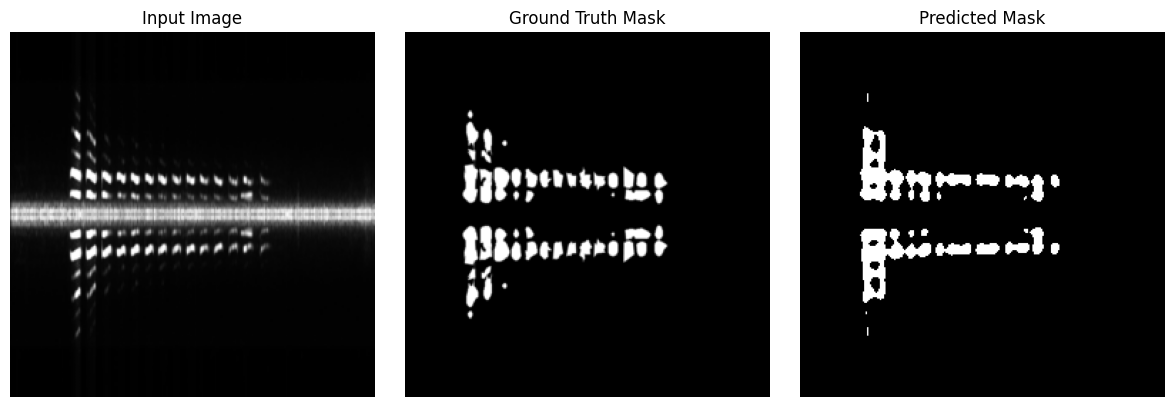

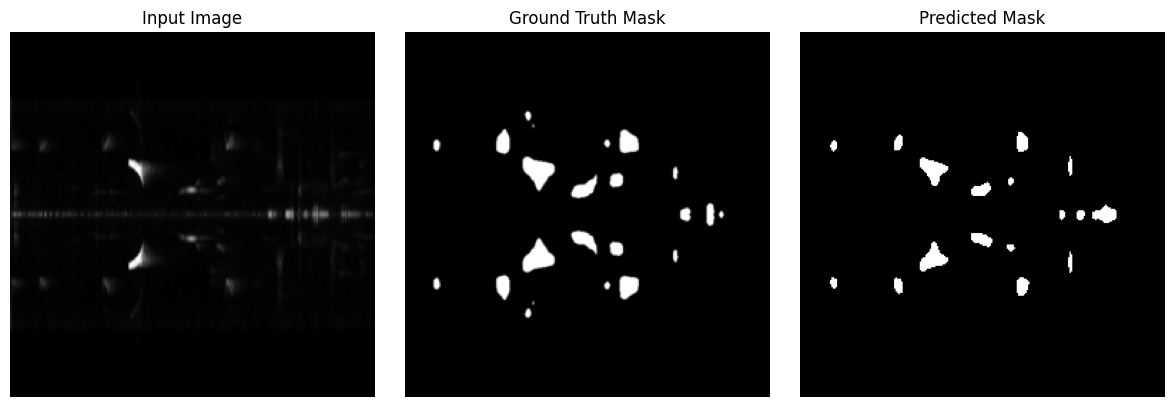

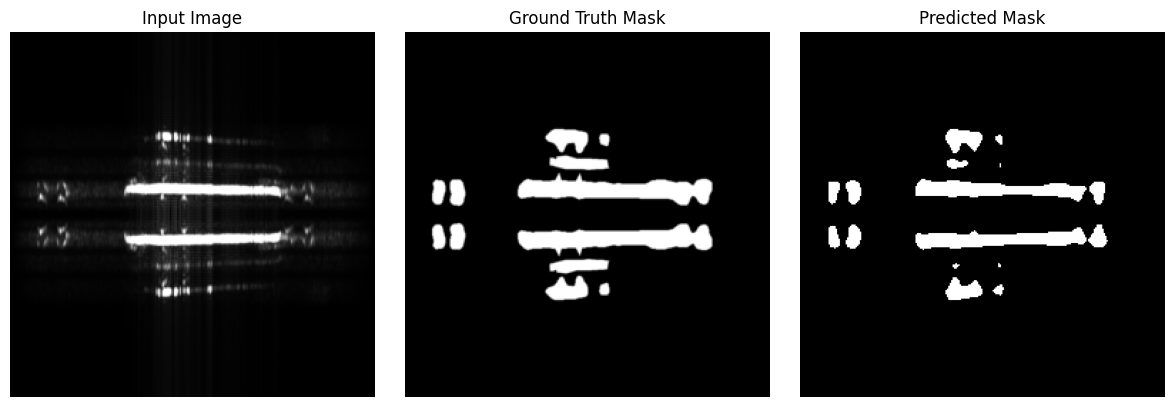

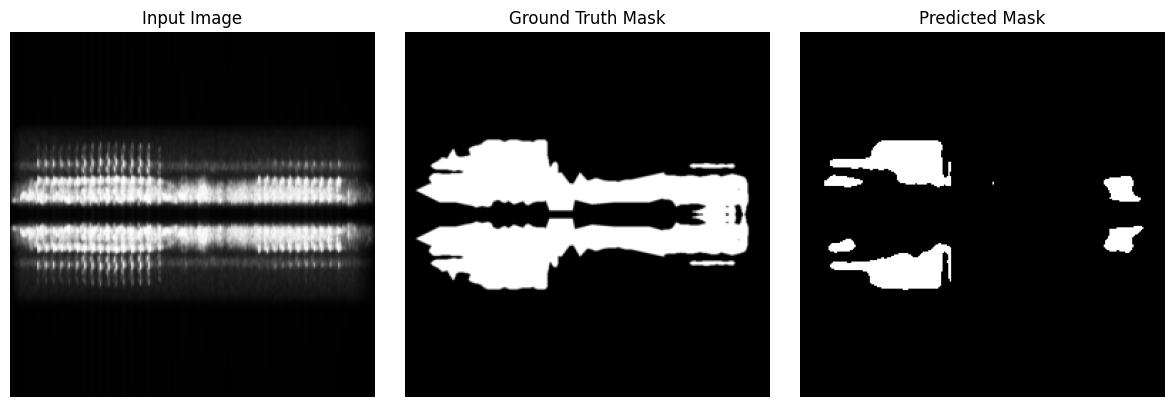

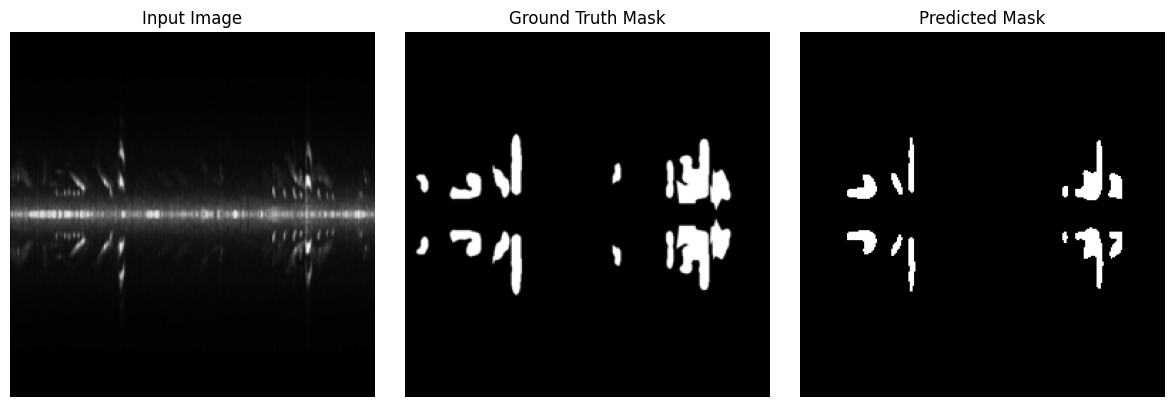

In [54]:
import torch
import os
import matplotlib.pyplot as plt

# If in a notebook, ensure:
# %matplotlib inline

# Load best model weights if not already done
model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))
model.eval()

intersection_sum = 0
union_sum = 0

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        # If masks have shape (N,1,H,W), remove that extra dimension
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)  # (N, H, W)

        outputs = model(images)  # (N, C, H, W)
        preds = torch.argmax(outputs, dim=1)  # (N, H, W)

        # Compute IoU for each image in the batch
        for p, m in zip(preds, masks):
            intersection = ((p == 1) & (m == 1)).sum().item()
            union = ((p == 1) | (m == 1)).sum().item()
            intersection_sum += intersection
            union_sum += union

        # Display a few predictions for visualization
        if batch_idx < 5:
            img_np = images[0].cpu().permute(1,2,0).numpy()  # (H,W,3)
            mask_np = masks[0].cpu().numpy()                 # (H,W)
            pred_np = preds[0].cpu().numpy()                 # (H,W)

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img_np)
            axes[0].set_title("Input Image")
            axes[1].imshow(mask_np, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(pred_np, cmap='gray')
            axes[2].set_title("Predicted Mask")

            for ax in axes:
                ax.axis('off')

            fig.tight_layout()

            # Display the figure inline
            plt.show()

            # If you also want to save the figure, uncomment this line:
            # plt.savefig(f"test_predictions/prediction_{batch_idx}.png")

            plt.close(fig)

# 4. Your IoU score should be higher than 60

In [55]:
# Calculate final IoU
iou = intersection_sum / union_sum if union_sum > 0 else 0.0
print(f"Test IoU: {iou * 100:.2f}%")

Test IoU: 61.42%
